# Thresolding

In this I will introduce you to image segmentation techniques i.e thresolding

Image segmentation project where we will use thresholding operations to segment a relatively simple image.
We will work through this project using the types of image processing techniques i.e Thresolding.

# Image segmentation is the process of partitioning a digital image into multiple segments to make the image easier to analyze.
Often we are looking to locate objects and boundaries in the original image.

A more precise way of looking at it is to say that image segmentation's goal is to assign a label to every pixel in an image 
such that pixels with the same label share certain characteristics.


Firstly we need to import some libraries such as Opencv and Numpy for read and storing the images in diagital format.Matplot lib is imported for displaying the image and its inline is use for static alignment of the image

In [40]:
# First import OpenCV, NumPY and MatPlotLib as we will use these libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
#matplot inline is use for static alignment of an image

We need to spereate the noise from image for that we will use fastN1MeansDenoisingColored i.e method in opencv. 
We're using a larger 'h' and 'hColor' value than typically used as the image is more noisy than images typically used with these technique.
(This should make more sense as we go forward into the CNN segmentation examples).

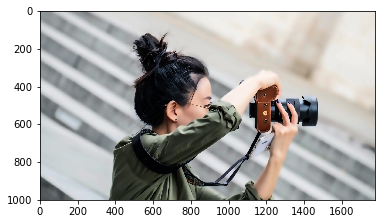

In [41]:
# Load a color image
img = cv2.imread("photo.jpg")
# Apply some blurring to reduce noise
# h is the Parameter regulating filter strength for luminance component. 
# Bigger h value perfectly removes noise but also removes image details, 
# smaller h value preserves details but also preserves some noise
# Hint: I recommend using larger h and hColor values than typical to remove noise at the
# expense of losing image details
# Experiment with setting h and hColor to a suitable value.

h=20
hColor=20
# Default values

templateWindowSize = 7
searchWindowSize = 21
#stored the image after denosing in blur    
blur = cv2.fastNlMeansDenoisingColored(img, None,h,hColor,templateWindowSize,searchWindowSize)
    
plt.imshow(cv2.cvtColor(blur, cv2.COLOR_BGR2RGB))

Now, lets run a morphological operation on the blurred image.

For this example, we are going to generate a gradient.

This builds on dilation and erosion.As dilation is adding pixels to bondary of an image and erosion is 
removing pixel from boundary of an image
Today we are going to use them to generate an outline for our Photographer.


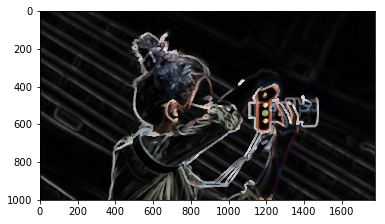

In [42]:
# Apply a morphological gradient (dilate the image, erode the image, and take the difference
##making a structuring element of 13x13 matrix
elKernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13,13))

# Use openCV's morphologyEx to generate a gradient using the kernel above 
gradient = cv2.morphologyEx(blur, cv2.MORPH_GRADIENT, elKernel)
#gradient show the directional change in intensity of an image
plt.imshow(cv2.cvtColor(gradient, cv2.COLOR_BGR2RGB))

Now we have completed the pre-processing of our image.

From this point onwards, we are concerning ourselves with:

a) filling the region of interest, and

b) removing artefacts from the image which we are not interested in.

There are quite a few approaches we can take to this (including not doing them at all), but lets apply 
OTSU's threshold to convert the image to black and white, and perform a closing operation to 'fill in' the 
photographer and then perform some erosion to remove parts of the image that we consider noise.



# OTSU Thresholding

When converting from a grayscale image to a black and white image, selecting a good threshold value can be a
time-consuming and manual process. There are a number of automatic thresholding techniques available - and 
Otsu's method thresholding is one of the better known techniques.


Conceptually simple, and relatively low cost computationally, Otsu's threshold iterate through all the possible threshold values to find the threshold value where the sum of foreground and background spreads is at its minimum.

Otsu form histogram of bimodlar image and if they are two peak in that histogram it consider the middle of the graph as the thresold value

In [43]:
# Apply Otsu's method - or you can adjust the level at which thresholding occurs
# and see what the effect of this is

# Convert gradient to grayscale
gradient = cv2.cvtColor(gradient, cv2.COLOR_BGR2GRAY)#Use for conversion

#Generate a matrix called otsu using OpenCV's threshold() function.  Use
# Otsu's method.

otsu = cv2.threshold(gradient, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

   
# Apply a closing operation - we're using a large kernel here. By all means adjust the size of this kernel
# and observe the effects
close = cv2.morphologyEx(otsu, cv2.MORPH_CLOSE, closingKernel)

#Remember: closing removes small holes 
#opening removes small object
closingKernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (33,33))


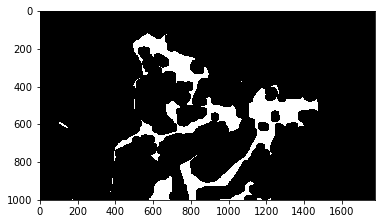

In [44]:
# Erode smaller artefacts out of the image - play with iterations to see how it works    
#  Generate a matrix called eroded using cv2.erode() function over the 'close' matrix.
eroded = cv2.erode(close, None, iterations=6)

plt.imshow(eroded, cmap='gray')

After switching to black and white and applying our closing and erosion operations, our simplified camera is starting to emerge
			
So, now we've effectively segmented our image.

Now, let's post-process the image to find the contours that represent the edge of the photographer(which contain camera).We'll just use the intuition that the photographer is the largest object in the scene.

Then we wil do a little image manipulation to generate a colour representing the camera,
another colour representing the background (i.e. i.e not the photographer) and then merge those colours with the original image.

You'll notice the closing and erosion steps are not perfect - they're not supposed to be. 
They are good enough to feed into the findContours routine.
By all means, tune them further to get better quality input into findContours.

In the findContours routine we're using cv2.RETR_EXTERNAL. 
This is to reduce the complexity of post-processing by only reporting 'external' contours
(i.e. we'll attempt to suppress contours that are inside other contours).

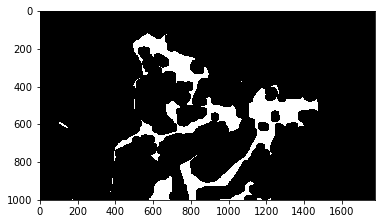

In [45]:
p = int(img.shape[1] * 0.05)
eroded[:, 0:p] = 0
eroded[:, img.shape[1] - p:] = 0

plt.imshow(eroded, cmap='gray')

Contours can be explained simply as a curve joining all the continuous points (along the boundary),
having same color or intensity. The contours are a useful tool for shape analysis and object detection and recognition.

In [46]:
#finding the counter in an image
(cnting, contours, _) = cv2.findContours(eroded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


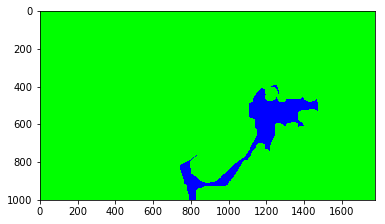

In [47]:
# Sort the candidates by size, and just keep the largest one
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

# Lets create two images, initially all zeros (i.e. black)
# One image will be filled with 'Blue' wherever we think there's some camera section present
# The other image will be filled with 'Green' whereever we think there's no camera
h, w, num_c = img.shape
segmask = np.zeros((h, w, num_c), np.uint8)
stencil = np.zeros((h, w, num_c), np.uint8)

#To draw the contours, cv2.drawContours function is used. It can also be used to draw any shape provided you have 
#its boundary points. Its first argument is source image, second argument is the contours which should be passed as a Python list, third argument is index of contours 
#(useful when drawing individual contour. To draw all contours, pass -1) and remaining arguments are color, thickness etc.
# I know we've only one contour, but - in general - we'd expect to have more contours to deal with
for c in contours:
    # Fill in the starfish shape into segmask
    cv2.drawContours(segmask, [c], 0, (255, 0, 0), -1)
    plt.imshow(cv2.cvtColor(segmask, cv2.COLOR_BGR2RGB))
    # Lets fill in the starfish shape into stencil as well
    # and then re-arrange the colors using numpy
    cv2.drawContours(stencil, [c], 0, (255, 0, 0), -1)
    plt.imshow(cv2.cvtColor(stencil, cv2.COLOR_BGR2RGB))
    stencil[np.where((stencil==[0,0,0]).all(axis=2))] = [0, 255, 0]
    plt.imshow(cv2.cvtColor(stencil, cv2.COLOR_BGR2RGB))
    stencil[np.where((stencil==[255,0,0]).all(axis=2))] = [0, 0, 0]
# Now, lets create a mask image by bitwise ORring segmask and stencil together
mask = cv2.bitwise_or(stencil, segmask)

plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))

In [48]:
# Now, lets just blend our original image with our mask

# Blend the original image 'img' and our mask 'mask'
# in any way you see fit, and store it in a variable called output
output = cv2.bitwise_or(mask, img)


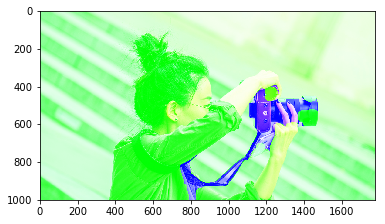

In [49]:
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))

Here we have finally got the image of camera after our output whcih was our concentration